### TAsk 0: Evaluation of Algorithms on IAPRTC dataset 

In [ ]:
import numpy as np
from multiprocessing import cpu_count
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

### Data Loading

In [32]:
def load_mat_data(file_path, data_key):
    """
    Load data from a .mat file and extract the specific key.
    
    Parameters:
    -----------
    file_path : str
        Path to the MAT file
    data_key : str
        Key to extract from the MAT file
        
    Returns:
    --------
    numpy.ndarray
        Extracted data
    """
    data = scipy.io.loadmat(file_path)
    return data[data_key][0][0]

def load_iaprtc_dataset(data_dir="./IAPRTC/"):
    """
    Load the IAPRTC-12 dataset from MAT files.
    
    Parameters:
    -----------
    data_dir : str, default="./IAPRTC/"
        Directory containing the dataset files
        
    Returns:
    --------
    tuple
        (train_features, train_labels, test_features, test_labels)
    """
    # Define file paths
    train_features_path = f"{data_dir}IAPRTC-12_TrainFeat.mat"
    train_labels_path = f"{data_dir}IAPRTC-12_TrainLabels.mat"
    test_features_path = f"{data_dir}IAPRTC-12_TestFeat.mat"
    test_labels_path = f"{data_dir}IAPRTC-12_TestLabels.mat"
    
    # Load data
    train_features = load_mat_data(train_features_path, 'I_x_tr')
    train_labels = load_mat_data(train_labels_path, 'I_z_tr')
    test_features = load_mat_data(test_features_path, 'I_x_te')
    test_labels = load_mat_data(test_labels_path, 'I_z_te')
    
    return train_features, train_labels, test_features, test_labels

def print_dataset_info(train_features, train_labels, test_features, test_labels):
    """
    Print information about the dataset shapes.
    
    Parameters:
    -----------
    train_features : numpy.ndarray
        Training features
    train_labels : numpy.ndarray
        Training labels
    test_features : numpy.ndarray
        Test features
    test_labels : numpy.ndarray
        Test labels
    """
    print(f"Train Features: {train_features.shape}, Train Labels: {train_labels.shape}")
    print(f"Test Features: {test_features.shape}, Test Labels: {test_labels.shape}")

In [33]:
train_features, train_labels, test_features, test_labels = load_iaprtc_dataset()
print_dataset_info(train_features, train_labels, test_features, test_labels)

Train Features: (17665, 2048), Train Labels: (17665, 291)
Test Features: (1962, 2048), Test Labels: (1962, 291)


### Model Evaluation

In [3]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate a multilabel classification model using various metrics.
    
    Parameters:
    -----------
    model : classifier object
        The trained model with a predict method
    X_test : array-like
        Test features
    y_test : array-like
        True test labels
    
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics for multilabel classification
    """
    # Get model predictions
    y_pred = model.predict(X_test)
    
    # Define metrics to calculate with their parameters
    metrics = {
        'accuracy': (accuracy_score, {}),
        'precision_micro': (precision_score, {'average': 'micro'}),
        'precision_macro': (precision_score, {'average': 'macro'}),
        'recall_micro': (recall_score, {'average': 'micro'}),
        'recall_macro': (recall_score, {'average': 'macro'}),
        'f1_micro': (f1_score, {'average': 'micro'}),
        'f1_macro': (f1_score, {'average': 'macro'}),
        'hamming_loss': (hamming_loss, {})
    }
    
    # Calculate all metrics
    results = {}
    for metric_name, (metric_func, params) in metrics.items():
        results[metric_name] = metric_func(y_test, y_pred, **params)
    
    return results

### Training of Models

In [18]:
def scale_features(X_train, X_test, scaler_path='scaler.pkl'):
    """
    Scale features using StandardScaler.
    
    Parameters:
    -----------
    X_train : array-like
        Training features to scale
    X_test : array-like
        Test features to scale
    scaler_path : str, default='scaler.pkl'
        Path to save/load the scaler
        
    Returns:
    --------
    tuple
        (X_train_scaled, X_test_scaled, scaler)
    """
    print("Scaling features...")
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        joblib.dump(scaler, scaler_path)
        
    return X_train_scaled, X_test_scaled, scaler

def apply_pca(X_train_scaled, X_test_scaled, n_components=200, pca_path='pca_model.pkl'):
    """
    Apply PCA to reduce feature dimensions.
    
    Parameters:
    -----------
    X_train_scaled : array-like
        Scaled training features
    X_test_scaled : array-like
        Scaled test features
    n_components : int, default=200
        Number of PCA components
    pca_path : str, default='pca_model.pkl'
        Path to save/load the PCA model
        
    Returns:
    --------
    tuple
        (X_train_reduced, X_test_reduced, pca)
    """
    print(f"Applying PCA to reduce dimensions to {n_components}")
    
    if os.path.exists(pca_path):
        pca = joblib.load(pca_path)
        X_train_reduced = pca.transform(X_train_scaled)
        X_test_reduced = pca.transform(X_test_scaled)
    else:
        pca = PCA(n_components=n_components)
        X_train_reduced = pca.fit_transform(X_train_scaled)
        X_test_reduced = pca.transform(X_test_scaled)
        joblib.dump(pca, pca_path)
    
    print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")
    return X_train_reduced, X_test_reduced, pca

def get_model_definitions():
    """
    Return a dictionary of model definitions for multilabel classification.
    
    Returns:
    --------
    dict
        Dictionary of model configurations
    """
    return {
        'Linear SVM': OneVsRestClassifier(LinearSVC(max_iter=1)),
        'Logistic Regression': OneVsRestClassifier(LogisticRegression(max_iter=1, n_jobs=1)),
        'Softmax Regression': OneVsRestClassifier(LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1, n_jobs=1)),
        'Decision Tree': OneVsRestClassifier(DecisionTreeClassifier(
            criterion='gini',
            max_depth=5,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )),
        'Weighted KNN': OneVsRestClassifier(KNeighborsClassifier(
            weights='distance',
            n_neighbors=5,
            algorithm='auto',
            leaf_size=30,
            p=2,
            n_jobs=1
        ))
    }

def train_and_save_model(model, X_train, y_train, model_name):
    """
    Train a model and save it to disk.
    
    Parameters:
    -----------
    model : classifier object
        The model to train
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    model_name : str
        Name of the model for saving
    
    Returns:
    --------
    None
    """
    print(f"Training {model_name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Save the trained model to disk
    joblib.dump(model, f'{model_name.replace(" ", "_").lower()}.pkl')
    
    training_time = time.time() - start_time
    print(f"Trained {model_name} in {training_time:.2f} seconds.")
    return model

def load_and_evaluate_models(X_test_scaled, X_test_reduced, y_test):
    """
    Load and evaluate pre-trained models.
    
    Parameters:
    -----------
    X_test_scaled : array-like
        Scaled test features
    X_test_reduced : array-like
        PCA-reduced test features
    y_test : array-like
        True test labels
    
    Returns:
    --------
    tuple
        (results, trained_models)
    """
    models = get_model_definitions()
    results = {}
    trained_models = {}

    # for name, model in models.items():
    #     # Train and save the model
    #     if name == 'Weighted KNN':
    #         model = train_and_save_model(model, X_test_reduced, y_test, name)
    #     else:
    #         model = train_and_save_model(model, X_test_scaled, y_test, name)
    
    for name in models.keys():
        # Load model
        model_path = f'{name.replace(" ", "_").lower()}.pkl'
        if os.path.exists(model_path):
            model = joblib.load(model_path)
        else:
            # Train and save the model
            if name == 'Weighted KNN':
                model = train_and_save_model(model, X_test_reduced, y_test, name)
            else:
                model = train_and_save_model(model, X_test_scaled, y_test, name) 

        # Evaluate model
        if name == 'Weighted KNN':
            metrics = evaluate_model(model, X_test_reduced, y_test)
        else:
            metrics = evaluate_model(model, X_test_scaled, y_test)
        
        results[name] = {'metrics': metrics, 'training_time': 10}
        print(f"{name} - "
              f"Accuracy: {metrics['accuracy']:.4f}, "
              f"Precision (Micro): {metrics['precision_micro']:.4f}, "
              f"Precision (Macro): {metrics['precision_macro']:.4f}, "
              f"Recall (Micro): {metrics['recall_micro']:.4f}, "
              f"Recall (Macro): {metrics['recall_macro']:.4f}, "
              f"F1 (Micro): {metrics['f1_micro']:.4f}, "
              f"F1 (Macro): {metrics['f1_macro']:.4f}, "
              f"Hamming Loss: {metrics['hamming_loss']:.4f}, "
              f"Training Time: {results[name]['training_time']:.2f} seconds")
        
        trained_models[name] = model
    
    return results, trained_models

def create_ensemble_model(trained_models, X_test_scaled, X_test_reduced, y_test, pca):
    """
    Create and evaluate an ensemble model using majority voting.
    
    Parameters:
    -----------
    trained_models : dict
        Dictionary of trained models
    X_test_scaled : array-like
        Scaled test features
    y_test : array-like
        True test labels
    pca : object
        PCA model for transforming features for KNN
        
    Returns:
    --------
    dict
        Results for ensemble model
    """
    print("Training Multilabel Ensemble...")
    start_time = time.time()
    
    # Create the ensemble prediction function
    def ensemble_predict(X_test_scaled, X_test_reduced):
        predictions = np.array([
            trained_models[name].predict(X_test_scaled) if name != 'Weighted KNN' 
            else trained_models['Weighted KNN'].predict(X_test_reduced) 
            for name in trained_models
        ])
        print(f"Predictions: {predictions}")
        print(f"Predictions shape: {predictions.shape}")
        ensemble_pred = sum(predictions) >= 3  # Majority voting
        return ensemble_pred.astype(int)
    
    print(X_test_scaled.shape)
    y_pred_ensemble = ensemble_predict(X_test_scaled, X_test_reduced)
    ensemble_time = time.time() - start_time
    print(f"Completed ensemble model in {ensemble_time:.2f} seconds.")
    
    # Calculate metrics for ensemble
    ensemble_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_ensemble),
        'precision_micro': precision_score(y_test, y_pred_ensemble, average='micro'),
        'precision_macro': precision_score(y_test, y_pred_ensemble, average='macro'),
        'recall_micro': recall_score(y_test, y_pred_ensemble, average='micro'),
        'recall_macro': recall_score(y_test, y_pred_ensemble, average='macro'),
        'f1_micro': f1_score(y_test, y_pred_ensemble, average='micro'),
        'f1_macro': f1_score(y_test, y_pred_ensemble, average='macro'),
        'hamming_loss': hamming_loss(y_test, y_pred_ensemble)
    }
    
    return {'metrics': ensemble_metrics, 'training_time': ensemble_time}

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    """
    Train, evaluate, and save classification models sequentially.
    
    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
        
    Returns:
    --------
    dict
        Dictionary of model performances
    """
    results = {}
    
    # Data preprocessing
    X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)
    X_train_reduced, X_test_reduced, pca = apply_pca(X_train_scaled, X_test_scaled)
    
    # Evaluate individual models
    results, trained_models = load_and_evaluate_models(X_test_scaled, X_test_reduced, y_test)
    
    # Create and evaluate ensemble model
    ensemble_results = create_ensemble_model(trained_models, X_test_scaled, X_test_reduced, y_test, pca)
    results['Ensemble'] = ensemble_results
    
    return results, trained_models

In [28]:
def create_metrics_dataframe(results):
    """
    Create a DataFrame from model evaluation results.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing model evaluation results
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing formatted metrics
    """
    metrics_df = pd.DataFrame(columns=[
        'Model', 'Accuracy', 'Precision (micro)', 'Precision (macro)', 
        'Recall (micro)', 'Recall (macro)', 'F1 (micro)', 'F1 (macro)', 
        'Hamming Loss', 'Training Time (s)'
    ])
    
    i = 0
    for model, data in results.items():
        metrics = data['metrics']
        metrics_df.loc[i] = [
            model,
            f"{metrics['accuracy']:.4f}",
            f"{metrics['precision_micro']:.4f}",
            f"{metrics['precision_macro']:.4f}",
            f"{metrics['recall_micro']:.4f}",
            f"{metrics['recall_macro']:.4f}",
            f"{metrics['f1_micro']:.4f}",
            f"{metrics['f1_macro']:.4f}",
            f"{metrics['hamming_loss']:.4f}",
            f"{data['training_time']:.2f}"
        ]
        i += 1
    
    return metrics_df

def print_metrics_table(metrics_df):
    """
    Print the metrics table to console.
    
    Parameters:
    -----------
    metrics_df : pd.DataFrame
        DataFrame containing formatted metrics
    """
    print("Evaluation Results:")
    print(metrics_df.to_string(index=False))
    
def extract_plot_data(metrics_df):
    """
    Extract and convert metrics data for plotting.
    
    Parameters:
    -----------
    metrics_df : pd.DataFrame
        DataFrame containing formatted metrics
        
    Returns:
    --------
    dict
        Dictionary containing extracted metrics as float values
    """
    return {
        'models': metrics_df['Model'],
        'accuracy': metrics_df['Accuracy'].astype(float),
        'precision_micro': metrics_df['Precision (micro)'].astype(float),
        'recall_micro': metrics_df['Recall (micro)'].astype(float),
        'f1_micro': metrics_df['F1 (micro)'].astype(float),
        'hamming_loss': metrics_df['Hamming Loss'].astype(float),
        'training_time': metrics_df['Training Time (s)'].astype(float)
    }

def plot_metric(ax, models, values, title, ylim=None, color='blue'):
    """
    Plot a single metric on the given axes.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Axes to plot on
    models : array-like
        Model names for x-axis
    values : array-like
        Values to plot
    title : str
        Title for the plot
    ylim : tuple, optional
        y-axis limits (min, max)
    """
    ax.bar(models, values, color=color)
    ax.set_title(title)
    if ylim:
        ax.set_ylim(ylim)
    ax.tick_params(axis='x', rotation=45)

def create_metrics_plots(plot_data):
    """
    Create and display plots for various metrics.
    
    Parameters:
    -----------
    plot_data : dict
        Dictionary containing metrics data for plotting
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Plot individual metrics
    plot_metric(axes[0, 0], plot_data['models'], plot_data['accuracy'], 'Accuracy', [0, 1], color='green')
    plot_metric(axes[0, 1], plot_data['models'], plot_data['precision_micro'], 'Precision (micro)', [0, 1], color='blue')
    plot_metric(axes[0, 2], plot_data['models'], plot_data['recall_micro'], 'Recall (micro)', [0, 1], color='red')
    plot_metric(axes[1, 0], plot_data['models'], plot_data['f1_micro'], 'F1 Score (micro)', [0, 1], color='teal')
    plot_metric(axes[1, 1], plot_data['models'], plot_data['hamming_loss'], 'Hamming Loss (lower is better)', color='orange')
    plot_metric(axes[1, 2], plot_data['models'], plot_data['training_time'], 'Evaluation Time (seconds)', color='navy')
    
    plt.tight_layout()
    plt.show()

def display_results(results):
    """
    Display the evaluation results in a table and plot the metrics.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing model evaluation results
    """
    # Create metrics DataFrame
    metrics_df = create_metrics_dataframe(results)
    
    # Print table
    print_metrics_table(metrics_df)
    
    # Extract data for plotting
    plot_data = extract_plot_data(metrics_df)
    
    # Create and display plots
    create_metrics_plots(plot_data)

In [19]:
print("Training and evaluating models...")
results, trained_models = train_and_evaluate_models(train_features, train_labels, test_features, test_labels)

Training and evaluating models...
Scaling features...
Applying PCA to reduce dimensions to 200
Explained variance ratio: 0.72
Linear SVM - Accuracy: 0.0183, Precision (Micro): 0.7566, Precision (Macro): 0.3211, Recall (Micro): 0.2255, Recall (Macro): 0.1026, F1 (Micro): 0.3475, F1 (Macro): 0.1398, Hamming Loss: 0.0164, Training Time: 10.00 seconds
Logistic Regression - Accuracy: 0.0000, Precision (Micro): 0.0704, Precision (Macro): 0.0554, Recall (Micro): 0.8624, Recall (Macro): 0.8201, F1 (Micro): 0.1302, F1 (Macro): 0.0975, Hamming Loss: 0.2230, Training Time: 10.00 seconds
Softmax Regression - Accuracy: 0.0000, Precision (Micro): 0.0704, Precision (Macro): 0.0554, Recall (Micro): 0.8624, Recall (Macro): 0.8201, F1 (Micro): 0.1302, F1 (Macro): 0.0975, Hamming Loss: 0.2230, Training Time: 10.00 seconds
Decision Tree - Accuracy: 0.0102, Precision (Micro): 0.5300, Precision (Macro): 0.3606, Recall (Micro): 0.2440, Recall (Macro): 0.1702, F1 (Micro): 0.3342, F1 (Macro): 0.2157, Hamming L

Evaluation Results:
              Model Accuracy Precision (micro) Precision (macro) Recall (micro) Recall (macro) F1 (micro) F1 (macro) Hamming Loss Training Time (s)
         Linear SVM   0.0183            0.7566            0.3211         0.2255         0.1026     0.3475     0.1398       0.0164             10.00
Logistic Regression   0.0000            0.0704            0.0554         0.8624         0.8201     0.1302     0.0975       0.2230             10.00
 Softmax Regression   0.0000            0.0704            0.0554         0.8624         0.8201     0.1302     0.0975       0.2230             10.00
      Decision Tree   0.0102            0.5300            0.3606         0.2440         0.1702     0.3342     0.2157       0.0188             10.00
       Weighted KNN   0.0347            0.8521            0.7372         0.3971         0.3194     0.5417     0.4265       0.0130             10.00
           Ensemble   0.0255            0.6429            0.5631         0.4830         0.36

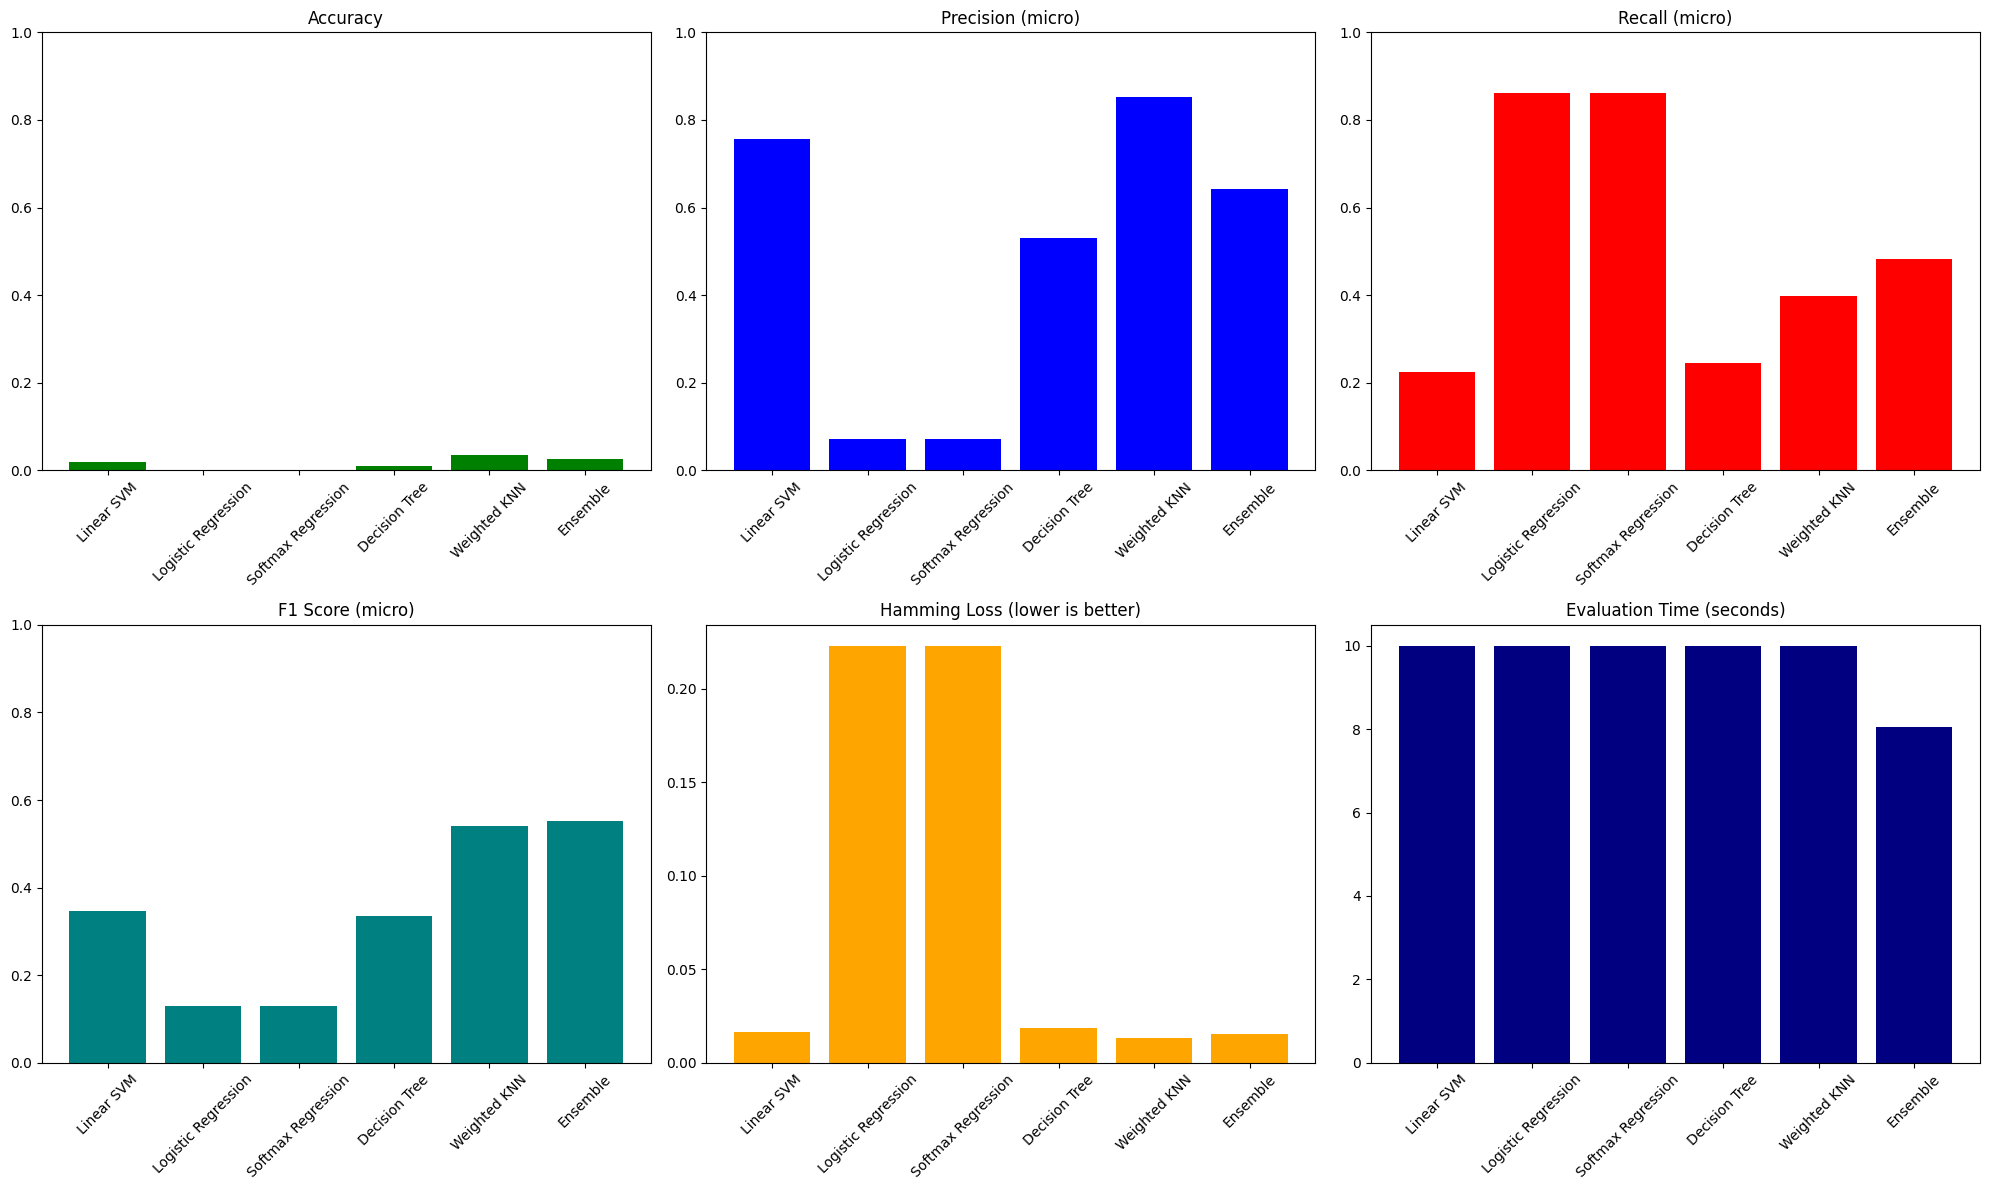

In [29]:
display_results(results)

In [15]:
def create_results_dataframe(results):
    """
    Create a DataFrame from model evaluation results.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing model evaluation results
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing model metrics
    """
    results_df = pd.DataFrame()
    for model, data in results.items():
        metrics = data['metrics']
        row = {
            'Model': model,
            'Accuracy': metrics['accuracy'],
            'Precision (micro)': metrics['precision_micro'],
            'Precision (macro)': metrics['precision_macro'],
            'Recall (micro)': metrics['recall_micro'],
            'Recall (macro)': metrics['recall_macro'],
            'F1 (micro)': metrics['f1_micro'],
            'F1 (macro)': metrics['f1_macro'],
            'Hamming Loss': metrics['hamming_loss'],
            'Training Time (s)': data['training_time']
        }
        results_df = pd.concat([results_df, pd.DataFrame([row])])
    
    return results_df

def save_results_to_csv(results_df, file_path='classification_results.csv'):
    """
    Save results DataFrame to a CSV file.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame containing model metrics
    file_path : str, default='classification_results.csv'
        Path where the CSV file will be saved
    """
    results_df.to_csv(file_path, index=False)
    print(f"Results saved to {file_path}")

def export_results_to_csv(results, file_path='classification_results.csv'):
    """
    Convert model results to DataFrame and save to CSV.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing model evaluation results
    file_path : str, default='classification_results.csv'
        Path where the CSV file will be saved
    """
    # Create DataFrame from results
    results_df = create_results_dataframe(results)
    
    # Save to CSV
    save_results_to_csv(results_df, file_path)

In [16]:
export_results_to_csv(results)

Results saved to classification_results.csv


In [30]:
model = joblib.load('logistic_regression.pkl')
scaler = joblib.load('scaler.pkl')
X_test_scaled = scaler.transform(test_features)
y_pred = model.predict(X_test_scaled)


In [31]:
y_pred[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0])

In [17]:
def calculate_precision_per_sample(all_predictions, true_labels, threshold=0.5):
    """
    Calculate precision-based accuracy score using majority voting.
    
    Parameters:
    -----------
    all_predictions : list of arrays
        List of model predictions (each array of shape (n_samples, n_labels))
    true_labels : array-like
        Ground truth labels (shape (n_samples, n_labels))
    threshold : float, default=0.5
        Proportion of models required to consider a label as predicted
        
    Returns:
    --------
    precision_scores : array
        Precision score for each sample (TP / actual positives)
    ensemble_predictions : array
        Ensemble predictions after majority voting
    support : array
        Number of actual positive labels for each sample
    """
    # Convert predictions to numpy array if not already
    all_predictions = np.array(all_predictions)
    
    # Stack predictions for easier processing
    stacked_preds = np.stack(all_predictions)
    
    # Get number of models
    n_models = stacked_preds.shape[0]
    
    # Calculate threshold count (number of models needed to vote for a label)
    threshold_count = int(n_models * threshold)
    
    # Apply majority voting
    ensemble_pred = np.sum(stacked_preds, axis=0) >= threshold_count
    ensemble_pred = ensemble_pred.astype(int)
    
    # Calculate precision per sample
    precision_scores = []
    support = []
    
    for i in range(true_labels.shape[0]):
        # Find matching indices (true positives)
        matching = np.where((ensemble_pred[i] == 1) & (true_labels[i] == 1))[0]
        
        # Count actual positives
        actual_positives = np.sum(true_labels[i])
        support.append(actual_positives)
        
        # Calculate precision (TP / actual positives)
        if actual_positives > 0:
            precision = len(matching) / actual_positives
        else:
            precision = 1.0 if np.sum(ensemble_pred[i]) == 0 else 0.0
            
        precision_scores.append(precision)
    
    return np.array(precision_scores), ensemble_pred, np.array(support)

def evaluate_ensemble_precision(trained_models, X_test, y_test, pca=None, threshold=0.5):
    """
    Evaluate ensemble precision using majority voting across all models.
    
    Parameters:
    -----------
    trained_models : dict
        Dictionary of trained models
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
    pca : object, optional
        PCA model for KNN
    threshold : float, default=0.5
        Threshold for majority voting
        
    Returns:
    --------
    results : dict
        Dictionary containing evaluation results
    """
    # Get predictions from all models
    all_predictions = []
    model_names = []
    
    print("Getting predictions from all models...")
    for name, model in trained_models.items():
        try:
            if name == 'Weighted KNN' and pca is not None:
                X_test_reduced = pca.transform(X_test)
                y_pred = model.predict(X_test_reduced)
            else:
                y_pred = model.predict(X_test)
                
            all_predictions.append(y_pred)
            model_names.append(name)
            print(f"  Got predictions from {name}")
        except Exception as e:
            print(f"  Error getting predictions from {name}: {e}")
    
    # Calculate precision scores for each sample
    precision_scores, ensemble_pred, support = calculate_precision_per_sample(
        all_predictions, y_test, threshold
    )
    
    # Calculate overall metrics
    mean_precision = np.mean(precision_scores)
    weighted_precision = np.sum(precision_scores * support) / np.sum(support)
    
    # Calculate standard metrics
    accuracy = accuracy_score(y_test, ensemble_pred)
    precision_micro = precision_score(y_test, ensemble_pred, average='micro')
    precision_macro = precision_score(y_test, ensemble_pred, average='macro')
    recall_micro = recall_score(y_test, ensemble_pred, average='micro')
    recall_macro = recall_score(y_test, ensemble_pred, average='macro')
    f1_micro = f1_score(y_test, ensemble_pred, average='micro')
    f1_macro = f1_score(y_test, ensemble_pred, average='macro')
    hamming = hamming_loss(y_test, ensemble_pred)
    
    # Return results
    results = {
        'ensemble_precision_mean': mean_precision,
        'ensemble_precision_weighted': weighted_precision,
        'sample_precision_scores': precision_scores,
        'ensemble_predictions': ensemble_pred,
        'standard_metrics': {
            'accuracy': accuracy,
            'precision_micro': precision_micro,
            'precision_macro': precision_macro,
            'recall_micro': recall_micro,
            'recall_macro': recall_macro,
            'f1_micro': f1_micro,
            'f1_macro': f1_macro,
            'hamming_loss': hamming
        },
        'models_used': model_names,
        'voting_threshold': threshold
    }
    
    return results

In [20]:
X_train_scaled, X_test_scaled, scaler = scale_features(train_features, test_features)
X_train_reduced, X_test_reduced, pca = apply_pca(X_train_scaled, X_test_scaled)

Scaling features...
Applying PCA to reduce dimensions to 200
Explained variance ratio: 0.72


In [21]:
ensemble_eval_results = evaluate_ensemble_precision(trained_models, X_test_scaled, test_labels, pca)

Getting predictions from all models...
  Got predictions from Linear SVM
  Got predictions from Logistic Regression
  Got predictions from Softmax Regression
  Got predictions from Decision Tree
  Got predictions from Weighted KNN


In [23]:
print("Ensemble Evaluation Results:")
for key, value in ensemble_eval_results.items():
    if key == 'standard_metrics':
        print(f"{key}:")
        for metric, metric_value in value.items():
            print(f"  {metric}: {metric_value:.4f}")
    else:
        print(f"{key}: {value}")

Ensemble Evaluation Results:
ensemble_precision_mean: 0.8712892221161173
ensemble_precision_weighted: 0.8688138966796345
sample_precision_scores: [0.9        0.44444444 1.         ... 0.66666667 1.         1.        ]
ensemble_predictions: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]
standard_metrics:
  accuracy: 0.0000
  precision_micro: 0.0709
  precision_macro: 0.0555
  recall_micro: 0.8688
  recall_macro: 0.8210
  f1_micro: 0.1311
  f1_macro: 0.0978
  hamming_loss: 0.2230
models_used: ['Linear SVM', 'Logistic Regression', 'Softmax Regression', 'Decision Tree', 'Weighted KNN']
voting_threshold: 0.5
